In [3]:
import datetime

import numpy as np
import pandas as pd

from scipy.io import mmread

import matplotlib.pyplot as plt

In [1]:
import os
os.__file__

'/home/ch6845/tools/miniconda3/envs/pytorch/lib/python3.6/os.py'

# load data

## expression data

In [4]:
exp_data=mmread('data/HumanLiver_extract/HumanLiver.data.counts.mm').toarray().astype(float)
with open('data/HumanLiver_extract/HumanLiver.data.col','r') as f: exp_data_col=[i.strip().strip('"') for i in f.read().split()]
with open('data/HumanLiver_extract/HumanLiver.data.row','r') as f: exp_data_row=[i.strip().strip('"') for i in f.read().split()]
assert exp_data.shape==(len(exp_data_row),len(exp_data_col))

In [5]:
assert len(set(exp_data_row))==len(exp_data_row)
assert len(set(exp_data_col))==len(exp_data_col)

In [6]:
exp_data,exp_data.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), (20007, 8444))

In [7]:
exp_data_row[:5],exp_data_col[:5]

(['RP11-34P13.7', 'FO538757.2', 'AP006222.2', 'RP4-669L17.10', 'RP5-857K21.4'],
 ['P1TLH_AAACCTGAGCAGCCTC_1',
  'P1TLH_AAACCTGTCCTCATTA_1',
  'P1TLH_AAACCTGTCTAAGCCA_1',
  'P1TLH_AAACGGGAGTAGGCCA_1',
  'P1TLH_AAACGGGGTTCGGGCT_1'])

## cluster info 

In [8]:
exp_data_meta=pd.read_csv('data/HumanLiver_extract/HumanLiver.metadata.tsv',sep='\t')
exp_data_meta.head()

,total_counts,total_features,orig.ident,res.0.8,S.Score,G2M.Score,Phase
P1TLH_AAACCTGAGCAGCCTC_1,2943,1427,P1TLH,12,0.046089,0.000349,S
P1TLH_AAACCTGTCCTCATTA_1,10897,2522,P1TLH,17,-0.000357,0.009434,G2M
P1TLH_AAACCTGTCTAAGCCA_1,1914,1018,P1TLH,12,0.012811,-0.056561,S
P1TLH_AAACGGGAGTAGGCCA_1,5574,1798,P1TLH,10,-0.011324,-0.047102,G1
P1TLH_AAACGGGGTTCGGGCT_1,3700,1417,P1TLH,2,0.057467,-0.003861,S


`clusterid_to_clustername` is used to convert integers in `res.0.8` to cell-type name

In [9]:
clusterid_to_clustername=pd.read_csv('data/HumanLiver_extract/HumanLiver.clusterid_to_clustername.tsv',sep='\t',header=None,index_col=0)
clusterid_to_clustername[1]=clusterid_to_clustername[1].str.replace(' ','_')
len(clusterid_to_clustername[1].unique()),

(11,)

## marker info

In [74]:
clustername_to_markers_new={'Cholangiocytes':['KRT19','EPCAM','FXYD2','CLDN4','CLDN10','SOX9','MMP7','CXCL1','CFTR','TFF2','KRT7','CD24'],
'Mature_B_cells':['MS4A1','IGHD','CD79A','PTPRC','IGKC','CD19'],
'Hepatocytes':['ALB','HAMP','ARG1','PCK1','AFP','BCHE'],
'LSECs':['CALCRL','VWF','PECAM1','CLEC14A','EMCN'],
'Hepatic_Stellate_Cells':['ACTA2','COL1A1','TAGLN','COL1A2','COL3A1','SPARC','RBP1','DCN','MYL9'],
'Macrophages':['CD68','MARCO','FCGR3A','LYZ','PTPRC','AIF1'],
'ab_T_cells':['CD2','CD3D','TRAC','IL32','CD3E','PTPRC'],
'gd_T_cells':['NKG7','FCGR3A','HOPX','GNLY','CMC1','KLRF1','CCL3','PTPRC'],
'NK_cells':['GZMK','KLRF1','CCL3','CMC1','NKG7','PTPRC'],
'Plasma_cells':['CD27','IGHG1','IGHA1','IGHM','CD79A','PTPRC','IGKC'],
'Erythroid_cells':['HBB','SLC25A37','CA1','ALAS2'],
'other':[]                           
}

"""
clustername2markers={'Hepatocytes':['ALB','HAMP','ARG1','PCK1','AFP','BCHE'],
'LSECs':['CALCRL','CD32B','VWF'],
'Cholangiocytes':['KRT19','EPCAM','FXDY2','CLDN4','CLDN10','SOX9','MMP7','CXCL1','CFTR','TFF2','KRT7','CD24'],
'Hepatic_Stellate_Cells':['ACTA2','COL1A1','TAGLN','COL1A2','COL3A1','SPARC','RBP1','DCN','MYL9'],
'Macrophages':['CD68','MARCO'],
'ab_T_cells':['CD2','CD3D','TRAC','IL32','CD3E'],
'gd_T_cells':['NKG7','FCGR3A','HOPX','GNLY'],
'NK_cells':['GZMK','KLRF1','CCL3','CMC1'],
'Plasma_cells':['CD27','IGHG1'],
'Mature_B_cells':['MS4A1','LTB','CD52','IGHD'],
'Erythroid_cells':['HBB','SLC25A37','CA1','ALAS2']
}
"""

#for key,value in clustername2markers_new.items():
#    for i in value:
#        print(markers_db[(markers_db['official gene symbol']==i)].shape)
#markers_db[(markers_db['official gene symbol']=='CD32B') |(markers_db['nicknames'].str.contains('CD32B'))]
clustername_to_markers_new

{'Cholangiocytes': ['KRT19',
  'EPCAM',
  'FXYD2',
  'CLDN4',
  'CLDN10',
  'SOX9',
  'MMP7',
  'CXCL1',
  'CFTR',
  'TFF2',
  'KRT7',
  'CD24'],
 'Mature_B_cells': ['MS4A1', 'IGHD', 'CD79A', 'PTPRC', 'IGKC', 'CD19'],
 'Hepatocytes': ['ALB', 'HAMP', 'ARG1', 'PCK1', 'AFP', 'BCHE'],
 'LSECs': ['CALCRL', 'VWF', 'PECAM1', 'CLEC14A', 'EMCN'],
 'Hepatic_Stellate_Cells': ['ACTA2',
  'COL1A1',
  'TAGLN',
  'COL1A2',
  'COL3A1',
  'SPARC',
  'RBP1',
  'DCN',
  'MYL9'],
 'Macrophages': ['CD68', 'MARCO', 'FCGR3A', 'LYZ', 'PTPRC', 'AIF1'],
 'ab_T_cells': ['CD2', 'CD3D', 'TRAC', 'IL32', 'CD3E', 'PTPRC'],
 'gd_T_cells': ['NKG7',
  'FCGR3A',
  'HOPX',
  'GNLY',
  'CMC1',
  'KLRF1',
  'CCL3',
  'PTPRC'],
 'NK_cells': ['GZMK', 'KLRF1', 'CCL3', 'CMC1', 'NKG7', 'PTPRC'],
 'Plasma_cells': ['CD27', 'IGHG1', 'IGHA1', 'IGHM', 'CD79A', 'PTPRC', 'IGKC'],
 'Erythroid_cells': ['HBB', 'SLC25A37', 'CA1', 'ALAS2'],
 'other': []}

In [11]:
clustername_unique=list(clustername_to_markers_new.keys())
exp_data_meta_clusterid_clusteridunique=clusterid_to_clustername.loc[exp_data_meta['res.0.8'].values][1].apply(lambda x: clustername_unique.index(x))

In [12]:
marker_unique=np.unique([j for i in list(clustername_to_markers_new.values()) for j in i])
marker_unique_exp_data_idx=[exp_data_row.index(marker) for marker in marker_unique]
marker_unique

array(['ACTA2', 'AFP', 'AIF1', 'ALAS2', 'ALB', 'ARG1', 'BCHE', 'CA1',
       'CALCRL', 'CCL3', 'CD19', 'CD2', 'CD24', 'CD27', 'CD3D', 'CD3E',
       'CD68', 'CD79A', 'CFTR', 'CLDN10', 'CLDN4', 'CLEC14A', 'CMC1',
       'COL1A1', 'COL1A2', 'COL3A1', 'CXCL1', 'DCN', 'EMCN', 'EPCAM',
       'FCGR3A', 'FXYD2', 'GNLY', 'GZMK', 'HAMP', 'HBB', 'HOPX', 'IGHA1',
       'IGHD', 'IGHG1', 'IGHM', 'IGKC', 'IL32', 'KLRF1', 'KRT19', 'KRT7',
       'LYZ', 'MARCO', 'MMP7', 'MS4A1', 'MYL9', 'NKG7', 'PCK1', 'PECAM1',
       'PTPRC', 'RBP1', 'SLC25A37', 'SOX9', 'SPARC', 'TAGLN', 'TFF2',
       'TRAC', 'VWF'], dtype='<U8')

In [13]:
pi_true=np.array([np.sum(exp_data_meta_clusterid_clusteridunique==i) for i in sorted(np.unique(exp_data_meta_clusterid_clusteridunique))])/exp_data_meta_clusterid_clusteridunique.shape[0]
M_true=np.array([np.mean(exp_data[marker_unique_exp_data_idx,:][:,exp_data_meta_clusterid_clusteridunique==i],axis=1) for i in sorted(np.unique(exp_data_meta_clusterid_clusteridunique))])

In [14]:
cell_size_factor=pd.read_csv('data/analysis/size_factor_cluster.tsv',sep='\t',header=None)[0].values.astype(float)#.reshape(-1,1)
cell_size_factor

array([1.0309219 , 2.38041632, 0.72895119, ..., 1.45360587, 0.51372201,
       0.40260243])

In [15]:
Y=exp_data[marker_unique_exp_data_idx].transpose().astype(float)
Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
marker_onehot=np.array([np.sum(np.eye(len(marker_unique))[[marker_unique.tolist().index(marker) for marker in value]],axis=0) for key,value in clustername_to_markers_new.items()])
marker_onehot.shape
#marker_onehot.T

(12, 63)

In [207]:
exp_data_col_patient=pd.Series(exp_data_col).str.slice(start=1,stop=2).astype(int).values
x_data_covariate=np.eye(len(np.unique(exp_data_col_patient)))[exp_data_col_patient-1]
x_data_intercept=np.array([np.ones(Y.shape[0])]).transpose()
x_data_null=np.concatenate([x_data_intercept,x_data_covariate[:,:]],axis=1)
x_data_null.shape

(8444, 6)

In [208]:
#exp_data.shape,cell_size_factor.shape,x_data_null.shape,Y.shape
#pd.Series(x_data_null[:,1][x_data_null[:,1]==1]).sort_values()
#exp_data_col_patient#.sort_values()
#x_data_null[:,1][x_data_null[:,1]==1]
#X

# Torch porting

In [345]:
# Asuume that the following variables are initialized

# Input
Y
s=cell_size_factor
X=x_data_null.copy()[:,[0, 1,2,3,4]]
X=x_data_null.copy()[:,[0, 1,2]]
# 234 x
# 34 x
# 123 x
rho=marker_onehot

delta_min=2
B=10
LR=1e-1

# Optional
EM_ITER_MAX=20
M_ITER_MAX=10000

BATCH_SIZE=Y.shape[0]
NUM_WORKERS=0

LOWER_BOUND=1e-10
THETA_LOWER_BOUND=1e-20


Q_diff_tolerance=1e-4
LL_diff_tolerance=1e-4
X.shape

(8444, 3)

In [346]:
#sum(X[:,3]==1)
X

array([[1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [347]:
import math
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.nn.parameter import Parameter

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [348]:
torch.set_default_dtype(torch.float64) 

In [349]:
device_cpu=torch.device("cpu")
device_cuda_list=[torch.device("cuda:{}".format(i)) for i in range(6)][::-1]

In [350]:
#from basic_tools import Cell_Dataset,Masked
class Masked_Function(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, mask):
        #print('aaaa')
        output=input
        ctx.save_for_backward(input, mask)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, mask = ctx.saved_tensors
        grad_input = grad_mask = None
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mul(mask)

        return grad_input, grad_mask
    
class Masked(nn.Module):    
    def __init__(self, mask):    
        super(Masked, self).__init__()
        
        self.mask = nn.Parameter(torch.Tensor(mask)==1, requires_grad=False)    
        
        
    def forward(self, input):
        return Masked_Function.apply(input, self.mask)

    def extra_repr(self):
        return 'mask={}'.format(self.mask.shape)  

In [351]:
import math
class NB_logprob(nn.Module):
    def __init__(self):
        super(NB_logprob,self).__init__()
        
    def forward(self,total_count,probs,value):
        
        #eps = torch.finfo(probs.dtype).eps
        #probs_clamped=probs.clamp(min=eps, max=1 - eps)        
        probs_clamped=probs
        logits=torch.log(probs_clamped) - torch.log1p(-probs_clamped)
        #logits=torch.log(probs_clamped)
        
        log_unnormalized_prob = (total_count * F.logsigmoid(-logits) +
                                 value * F.logsigmoid(logits))
        log_normalization = (-torch.lgamma(total_count + value) + torch.lgamma(1. + value) +
                             torch.lgamma(total_count))

        return log_unnormalized_prob - log_normalization
    
class Normal_logprob(nn.Module):
    def __init__(self):
        super(Normal_logprob,self).__init__()
        
    def forward(self,loc,scale,value):
    
        var = (scale ** 2)
        log_scale = torch.log(scale)
        
        
        #print(loc.shape,scale.shape,value.shape)
        return -((value - loc) ** 2) / (2 * var) - log_scale - math.log(math.sqrt(2 * math.pi))    
        #return log_scale
        
class Poisson_logprob(nn.Module):
    def __init__(self):
        super(Poisson_logprob,self).__init__()
        
    def forward(self,rate,value):
        #rate=rate.clamp(min=1e-3)+(-1)/rate.clamp(max=-1e-5)
        
        return (rate.log() * value) - rate - (value + 1).lgamma()
    
class Dirichlet_logprob(nn.Module):
    def __init__(self):
        super(Dirichlet_logprob,self).__init__()
        
    def forward(self,concentration,value):
        
        return ((torch.log(value) * (concentration - 1.0)).sum(-1) +
                torch.lgamma(concentration.sum(-1)) -
                torch.lgamma(concentration).sum(-1))
    
        
NB_logprob=NB_logprob()        
normal_logprob=Normal_logprob()
poisson_logprob=Poisson_logprob()
dirichlet_logprob=Dirichlet_logprob()

In [352]:
#(a.clamp(min=0.0001).log() * b) - a - (b + 1).lgamma()
#(a.clamp(min=0).log() * b) - 1
#a.clamp(min=0)+
#(-1)/
#(a.clamp(min=1e-3)+(-1)/a.clamp(max=-1e-5))#.log()
#a.clamp(m=1e-3)

In [353]:
class Cell_Dataset(Dataset):
    def __init__(self,Y,X,s):
        self.Y=Y
        self.X=X
        self.s=s
        
    def __len__(self):
        return self.Y.shape[0]
    
    def __getitem__(self,idx):
        item= {"Y":self.Y[idx,:],"X":self.X[idx,:],"s":self.s[idx]}
        return item  

In [354]:
#X.shape

In [355]:
def run_EM():
    global gamma_new,Q_new,LL_new
    
    print('Start time:',datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    with torch.no_grad():
        for batch_idx,batch in enumerate(cell_dataloader):
            batch_Y=batch['Y'].to(device)
            batch_X=batch['X'].to(device)
            batch_s=batch['s'].to(device)    
        gamma_fixed,_,LL_old=model(batch_Y,batch_X,batch_s,gamma_fixed=None,mode='LL')
        _,Q_old,_=model(batch_Y,batch_X,batch_s,gamma_fixed=gamma_fixed,mode='M')

    print(LL_old)
    print(Q_old)

    for em_idx in range(EM_ITER_MAX):#
        #optimizer = optim.Adam(model.parameters(),lr=0.1,eps=1e-3,betas=(0.9,0.999))
        LL_new=torch.zeros_like(LL_old)
        #optimizer = optim.Adam(model.parameters(),lr=LR)
        for batch_idx,batch in enumerate(cell_dataloader):
            # It is usually just one iteration(batch).
            # However, developer of cellAssign may have done this for extreme situation of larse sample size
            batch_Y=batch['Y'].to(device)
            batch_X=batch['X'].to(device)
            batch_s=batch['s'].to(device)

            #############
            #E-step
            ######### ####
            with torch.no_grad():
                gamma_new,_,_=model(batch_Y,batch_X,batch_s,gamma_fixed=None,mode='E')

            #############
            #M-step
            #############
            for m_idx in range(M_ITER_MAX):#
            #for m_idx in range(20):#    
                optimizer.zero_grad()
                _,Q_new,_=model(batch_Y,batch_X,batch_s,gamma_fixed=gamma_new,mode='M')
                #print('Q',Q)
                Q_new.backward()
                #model.delta_log.grad[model.delta_log.grad>0]=0
                optimizer.step()
                """
                if sum(model.delta_log.grad[0]<0)>0:
                    #print('grad',model.delta_log.grad[0][model.delta_log.grad[0]<0])
                    #print('before',model.delta_log[0][model.delta_log.grad[0]<0])
                    optimizer.step()
                    print('after',model.delta_log[0][model.delta_log.grad[0]<0])
                    print('--')
                else:
                    optimizer.step()
                """
                model.delta_log.data=model.delta_log.data.clamp(min=model.delta_log_min)
                model.NB_basis_a.data=model.NB_basis_a.data.clamp(min=0)
                #delta_log.data=model.delta_log.data.clamp(min=model.delta_log_min)
                #optimizer.zero_grad()

                if m_idx%20==0:
                    #print(sorted(model.delta_log.cpu().detach().numpy().flatten())[-10:])
                    Q_diff=(Q_old-Q_new)/torch.abs(Q_old)
                    Q_old=Q_new
                    print('M: {}, Q: {} Q_diff: {}'.format(m_idx,Q_new,Q_diff))    
                    if m_idx>0 and torch.abs(Q_diff)<Q_diff_tolerance:
                        print('M break')
                        break                
                    """
                    print('M: {}, Q: {}'.format(m_idx,Q_new))    
                    if m_idx!=0:   
                        Q_diff=(Q_old-Q_new)/torch.abs(Q_old)
                        print('M: {}, Q: {} Q_diff: {}'.format(m_idx,Q_new,Q_diff))    
                    """
            #############
            #Look at LL
            #############
            with torch.no_grad():
                _,_,LL_temp=model(batch_Y,batch_X,batch_s,gamma_fixed=None,mode='LL')
                LL_new+=LL_temp

        LL_diff=(LL_new-LL_old)/torch.abs(LL_old)
        LL_old=LL_new
        print('EM: {}, LL: {} LL_diff: {}'.format(em_idx,LL_new,LL_diff))
        if LL_diff<LL_diff_tolerance:
            print('EM break')
            break
    print('End time:',datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))    
    return gamma_new,Q_new,LL_new

In [411]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.distributions.negative_binomial import NegativeBinomial
from torch.distributions.normal import Normal
from torch.distributions.dirichlet import Dirichlet

class Custom_Model(nn.Module):
    def __init__(self,Y,rho,X_col=5,delta_min=2,LOWER_BOUND=1e-10,THETA_LOWER_BOUND=1e-20):
        # Y,rho are needed for model parameter initialization
        super(Custom_Model, self).__init__()
        
        #rho
        self.masked=Masked(rho)
         
        #delta
        self.delta_log_min=np.log(delta_min) #
        self.delta_log=nn.Parameter(torch.Tensor(np.random.uniform(-2,2,size=rho.shape)),requires_grad=True) # (C,G)
        self.delta_log.data=self.delta_log.data.clamp(min=self.delta_log_min)

        
        self.delta_log_mean=nn.Parameter(0*torch.ones(1),requires_grad=True)        
        self.delta_log_variance=nn.Parameter(1*torch.ones(1),requires_grad=True)           
        
        Y_colmean=np.mean(Y,axis=0)
        beta_init=np.hstack([((Y_colmean-Y_colmean.mean())/np.std(Y_colmean)).reshape(-1,1),\
                     np.zeros((Y.shape[1],X_col-1))]).T
        self.beta=nn.Parameter(torch.Tensor(beta_init),requires_grad=True) # (P,G)
        
        #print(((np.mean(Y,axis=0)-np.mean(Y))/np.std(np.mean(Y,axis=0))).reshape(-1,1))
        #print(self.beta)
        
        self.NB_basis_mean=nn.Parameter(torch.Tensor(np.linspace(np.min(Y),np.max(Y),B)), requires_grad=False)
        self.NB_basis_a=nn.Parameter(torch.ones(B),requires_grad=True) # not consistent with paper.. hmm. strange...
        self.NB_basis_b=nn.Parameter((1/(2*((np.max(Y)-np.min(Y))/(B-1))**2))*torch.ones(B),requires_grad=False) # hmm... strange
        
        self.theta_logit=nn.Parameter(torch.Tensor(np.random.normal(loc=0.,scale=1.,size=rho.shape[0])),requires_grad=True)
        """
        self.theta_logit=nn.Parameter(torch.Tensor([0.90451505, -0.17513191, -0.61222912, -1.13814875, -0.95772558,\
       -0.06330393,  1.01599931, -0.79205052,  1.54521284,  0.32902628,\
        0.82969872, -0.11015047]),requires_grad=True)
        """
        self.LOWER_BOUND=LOWER_BOUND
        self.THETA_LOWER_BOUND=THETA_LOWER_BOUND
        
    def forward(self,Y,X,s,gamma_fixed=None,mode='E'):
        
        #self.delta_log.data=self.delta_log.data.clamp(min=self.delta_log_min)
        delta_log_masked=self.masked(self.delta_log) #(C,G)
        delta=torch.exp(delta_log_masked)*self.masked.mask
        
        X_beta_s=X.matmul(self.beta)+torch.log(s.view(-1, 1)) #(N,P)*(P,G) + (N,1) = (N,G)
        
        #mu_log=X_beta_s.view((X_beta_s.shape[0],1,X_beta_s.shape[1]))+delta #(N,1,G)+(C,G) = (N,C,G)
        mu_log=X_beta_s.unsqueeze(dim=1).repeat(1,delta.shape[0],1)+delta #(N,1,G)+(C,G) = (N,C,G)
        #mu_log=X_beta_s.unsqueeze(dim=1).repeat(1,,1)+delta #(N,1,G)+(C,G) = (N,C,G)
        
        mu=torch.exp(mu_log) # (N,C,G)
        
        #Y_extend=Y.view(Y.shape[0],1,Y.shape[1]).repeat(1,mu_log.shape[1],1) # (N,C,G)
        Y_extend=Y.unsqueeze(dim=1).repeat(1,mu_log.shape[1],1)
        #print(Y_extend)
        # Negative Binomial
        phi_B=self.NB_basis_a*torch.exp(-self.NB_basis_b*(mu_log.unsqueeze(dim=3).repeat(1,1,1,B)-self.NB_basis_mean)**2) # (N,C,G,B)

        phi=torch.sum(phi_B,axis=3)+self.LOWER_BOUND
        #print(mu.shape,phi.shape,Y_extend.shape)
        #print(phi)
        #Y_logprob=NB_logprob(total_count=phi,probs=(mu/(mu+phi)),value=Y_extend) # (N,C,G)
        #print(Y_logprob)
        # Normal
        #Y_logprob=normal_logprob(loc=mu_log,scale=torch.ones(1).to(device),value=Y_extend) # (N,C,G)
        #print(self.delta_log.max())
        # Poisson
        #Y_logprob=poisson_logprob(rate=mu,value=Y_extend) # (N,C,G)
        #prin
        theta_log=F.log_softmax(self.theta_logit,dim=0) # (C)          
        Y_logprob_reduce=torch.sum(Y_logprob,axis=2)+theta_log # (N,C)
        
        Y_logprob_reduce_reduce=torch.logsumexp(Y_logprob_reduce,dim=1).view(-1,1) # (N,1)
        
        gamma=torch.exp(Y_logprob_reduce-Y_logprob_reduce_reduce) # (N,C)
        #print(theta_log)
        #print(Y_extend[:,:,-5:])
        #print(Y_logprob)
        #print(mu)
        #print(phi)
        #value=gamma
        #print(gamma[-7:,:])
        #print('aaa')
        if mode=='E':
            return gamma,None,None
        elif mode=='M' or mode=='LL':
            theta_log_prob=dirichlet_logprob(concentration=1e-2*torch.ones_like(theta_log),value=(torch.exp(theta_log)+self.THETA_LOWER_BOUND))
            #print(1e-2*torch.ones_like(theta_log))
            delta_log_prob=torch.sum(normal_logprob(loc=self.delta_log_mean*self.masked.mask,scale=self.delta_log_variance,value=delta_log_masked))            
            if mode=='M':
                Q=-torch.sum(gamma_fixed*Y_logprob_reduce) # (N,C) (N,C)
                Q=Q-theta_log_prob
                Q=Q-delta_log_prob
                return gamma,Q,None
            elif mode=='LL':      
                LL=torch.sum(Y_logprob_reduce_reduce) # product of likelihood(y_i)-> (1) 
                print(LL,theta_log_prob,delta_log_prob)
                LL=LL+theta_log_prob
                LL=LL+delta_log_prob
                return gamma,None,LL
        else:
            raise 
"""

optimizer = optim.Adam(model.parameters(),lr=LR)


    
model(batch_Y,batch_X,batch_s,gamma_fixed=gamma,mode='M')[1].backward()
optimizer.step()
model(batch_Y,batch_X,batch_s,gamma_fixed=gamma,mode='M')
"""            
#batch_Y.unsqueeze(dim=1).repeat(1,2,1).shape

#model(batch_Y,batch_X,batch_s,gamma_fixed=gamma_new,mode='M') 
model=Custom_Model(Y,rho,X_col=X.shape[1],delta_min=delta_min,LOWER_BOUND=LOWER_BOUND,THETA_LOWER_BOUND=THETA_LOWER_BOUND).to(device)
with torch.no_grad():
    gamma,_,_=model(batch_Y,batch_X,batch_s,gamma_fixed=gamma_new,mode='M')            

In [399]:
#-model.NB_basis_mean.cpu()
#temp=torch.rand((3,4))
#temp
model.temp_a.shape,model.temp_b
model.temp_a.unsqueeze(dim=1).repeat(1,12,1)[:3],model.temp_b
#(model.temp_a.unsqueeze(dim=1).repeat(1,12,1)[:3]+model.temp_b)[:,4,:]#[4][:]
F.log_softmax(torch.ones(10),dim=0)

AttributeError: 'Custom_Model' object has no attribute 'temp_a'

In [400]:
a=Y.mean(axis=0)
(a-a.mean())/a.std()

array([-0.25593119, -0.25875499, -0.19126437, -0.26126088,  6.51306525,
       -0.16640187, -0.22586056, -0.231424  , -0.25855863, -0.18546718,
       -0.26889074, -0.24573934, -0.25812852, -0.25498681, -0.24103613,
       -0.24842289, -0.24172806, -0.26146658, -0.26954526, -0.26770325,
       -0.26795571, -0.25321025, -0.17666852, -0.25957782, -0.26276628,
       -0.26305614, -0.2663381 , -0.26368261, -0.26386026, -0.26814271,
       -0.23306966, -0.25886719, -0.18213846, -0.24562714,  0.04445721,
        2.25331155, -0.25477175,  0.50160375, -0.26878788,  0.42653002,
        0.31548561,  3.41443439, -0.19710832, -0.24552429, -0.26539372,
       -0.2647579 , -0.16789792, -0.22374739, -0.26926475, -0.2677126 ,
       -0.26428103, -0.10295994, -0.14781343, -0.24975998, -0.23282655,
       -0.2546689 , -0.24245738, -0.26838582, -0.24746915, -0.22731921,
       -0.2560808 , -0.24464536, -0.24772161])

In [401]:
torch.sum(a.cpu().unsqueeze(dim=3).repeat(1,1,1,B),axis=3).shape

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [402]:
model=Custom_Model(Y,rho,X_col=X.shape[1],delta_log_min=delta_log_min,LOWER_BOUND=LOWER_BOUND,THETA_LOWER_BOUND=THETA_LOWER_BOUND).to(device)

with torch.no_grad():
    a,b=model(batch_Y,batch_X,batch_s,gamma_fixed=None,mode='E')
a,b

NameError: name 'delta_log_min' is not defined

In [412]:
cell_dataset=Cell_Dataset(Y,X,s)
#cell_dataset=Cell_Dataset(Y[exp_data_col_patient==1],X[exp_data_col_patient==1],s[exp_data_col_patient==1])
#cell_dataloader=DataLoader(dataset=cell_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS)
cell_dataloader=DataLoader(dataset=cell_dataset,shuffle=False,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS)
#X

In [416]:
device=device_cuda_list[0]#
model=Custom_Model(Y,rho,X_col=X.shape[1],delta_min=delta_min,LOWER_BOUND=LOWER_BOUND,THETA_LOWER_BOUND=THETA_LOWER_BOUND).to(device)
optimizer = optim.Adam(model.parameters(),lr=LR)#,betas=(0.92, 0.999))

In [417]:
for batch_idx,batch in enumerate(cell_dataloader):
    # It is usually just one iteration(batch).
    # However, developer of cellAssign may have done this for extreme situation of larse sample size
    batch_Y=batch['Y'].to(device)
    batch_X=batch['X'].to(device)
    batch_s=batch['s'].to(device)

In [418]:
with torch.no_grad():
    gamma_value=model(batch_Y,batch_X,batch_s,gamma_fixed=None,mode='E')
#value=model(batch_Y,batch_X,batch_s,gamma_fixed=gamma_value,mode='M')

#value
#
#value
#value.sum().backward(retain_graph=True)
#
#optim.Adam?
gamma_value

(tensor([[1.3329e-35, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.4417e-36,
          1.0000e+00],
         [1.3210e-54, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.9883e-80,
          1.0000e+00],
         [1.2366e-25, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.5307e-25,
          1.0000e+00],
         ...,
         [2.7951e-34, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.8511e-49,
          1.0000e+00],
         [1.5722e-18, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 4.3162e-18,
          9.9999e-01],
         [7.3172e-15, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.4546e-13,
          1.0000e+00]], device='cuda:5'), None, None)

In [419]:
gamma_value,Q_value,LL_value=run_EM()

Start time: 2020-04-28 15:13:51
tensor(-7325239.2003, device='cuda:5') tensor(-17.7194, device='cuda:5') tensor(-1050.1316, device='cuda:5')
tensor(-7326307.0513, device='cuda:5')
tensor(7326407.7522, device='cuda:5')
M: 0, Q: 7326407.75219895 Q_diff: 0.0
M: 20, Q: 2220057.4439944034 Q_diff: 0.6969787214848812
M: 40, Q: 2074350.8098435954 Q_diff: 0.06563192071672146
M: 60, Q: 2027630.2617222208 Q_diff: 0.022522973404338134
M: 80, Q: 2008023.494459304 Q_diff: 0.00966979415974156
M: 100, Q: 2002412.5836171887 Q_diff: 0.0027942456139568874
M: 120, Q: 1999660.4301399074 Q_diff: 0.0013744187885145027
M: 140, Q: 1998234.5112181932 Q_diff: 0.0007130805311851961
M: 160, Q: 1997367.0660553824 Q_diff: 0.0004341057858529458
M: 180, Q: 1996814.792637663 Q_diff: 0.00027650071291607735
M: 200, Q: 1996454.878567422 Q_diff: 0.00018024409252572556
M: 220, Q: 1996216.599975807 Q_diff: 0.00011935085244006481
M: 240, Q: 1996057.055877897 Q_diff: 7.99232397485675e-05
M break
tensor(-1849252.7563, device='c

In [373]:
#NB 1,2 7640
#N 1,2 3369 
#P 1,2 7300 40sec 9iters LL: -1116555.195284147

(7775, 4920, 4512, 4548, 7705, 7640)

In [110]:
full0=pd.read_csv('data/analysis/cellassign_fit.prob.tsv',sep='\t').values#.idxmax(axis=1)#.value_counts()
full1=pd.read_csv('data/analysis/cellassign_fit_full.prob.tsv',sep='\t').values#.idxmax(axis=1)#.value_counts()
full2=pd.read_csv('data/analysis/cellassign_fit_full2.prob.tsv',sep='\t').values#.idxmax(axis=1)#.value_counts()
full3=pd.read_csv('data/analysis/cellassign_fit_full3.prob.tsv',sep='\t').values#.idxmax(axis=1)#.value_counts()

In [420]:
sum(np.argmax(full0,axis=1)==exp_data_meta_clusterid_clusteridunique.values),\
sum(np.argmax(full1,axis=1)==exp_data_meta_clusterid_clusteridunique.values),\
sum(np.argmax(full2,axis=1)==exp_data_meta_clusterid_clusteridunique.values),\
sum(np.argmax(full3,axis=1)==exp_data_meta_clusterid_clusteridunique.values),\
sum(np.argmax(test3,axis=1)==exp_data_meta_clusterid_clusteridunique.values),\
sum(np.argmax(gamma_new.cpu().numpy(),axis=1)==exp_data_meta_clusterid_clusteridunique.values),\

(7775, 4920, 4512, 4548, 7705, 7412)

In [395]:
!pwd

/scratch/ch6845/dynamic_cell_classifier


In [ ]:
#dict(model.named_parameters()).keys(),model.delta_log.T*model.masked.mask.T
gamma_new.cpu().numpy()[exp_data_col_patient==1].shape

In [ ]:
np.sum(np.argmax(gamma_value.cpu().numpy(),axis=1)==exp_data_meta_clusterid_clusteridunique.values[exp_data_col_patient==1])

In [ ]:
np.sum(np.argmax(gamma_new.cpu().numpy()[exp_data_col_patient==1],axis=1)==exp_data_meta_clusterid_clusteridunique.values[exp_data_col_patient==1])#gamma_new.cpu().numpy()[exp_data_col_patient==1].shape

In [ ]:
np.sum(np.argmax(gamma_new.cpu().numpy(),axis=1)==exp_data_meta_clusterid_clusteridunique.values)

In [371]:
np.sum(np.argmax(gamma_new.cpu().numpy()[exp_data_col_patient==1],axis=1)==exp_data_meta_clusterid_clusteridunique.values[exp_data_col_patient==1])#gamma_new.cpu().numpy()[exp_data_col_patient==1].shape

800

In [ ]:
#np.sum(np.argmax(gamma_value.cpu().numpy(),axis=1)==exp_data_meta_clusterid_clusteridunique.values)
#gamma_new.cpu()
#model.delta_log#.grad#model.beta
#np.unique(np.argmax(gamma_new.cpu().numpy(),axis=1),return_counts=True)
#model.delta_log.max(),model.delta_log,model.delta_log.grad
#model.NB_basis_b
#sum(pd.read_csv('temp.tsv',sep='\t',header=None,index_col=0).idxmax(axis=1).values==exp_data_meta_clusterid_clusteridunique.values)
#!ls data/analysis/cellassign_fit_full2.prob.tsv
test1=pd.read_csv('data/analysis/cellassign_fit_full.prob.tsv',sep='\t').values#.idxmax(axis=1)#.value_counts()
test2=pd.read_csv('data/analysis/cellassign_fit_full2.prob.tsv',sep='\t').values#.idxmax(axis=1)#.value_counts()
test3=pd.read_csv('temp3.tsv',sep='\t').values#.idxmax(axis=1)#.value_counts()
test=pd.read_csv('temp2.tsv',sep='\t').values
np.sum(np.argmax(test3,axis=1)==exp_data_meta_clusterid_clusteridunique.values)


In [56]:
np.sum(np.argmax(test3,axis=1)==np.argmax(gamma_new.cpu().numpy(),axis=1))

8198

In [71]:
test3=pd.read_csv('/data01/ch6845/single_cell/temp3.tsv',sep='\t').values#.idxmax(axis=1)#.value_counts()

In [ ]:
sum(np.argmax(gamma_value.cpu().numpy(),axis=1)==exp_data_meta_clusterid_clusteridunique.values)

In [50]:
test3=pd.read_csv('temp3.tsv',sep='\t').values#.idxmax(axis=1)#.value_counts()

In [373]:
#NB 1,2 7640
#N 1,2 3369

(7775, 4920, 4512, 4548, 7705, 7640)

In [102]:
sum(np.argmax(gamma_value.cpu().numpy(),axis=1)==exp_data_meta_clusterid_clusteridunique.values)

7692

In [103]:
np.unique(np.argmax(gamma_value.cpu().numpy(),axis=1),return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 125,  115, 3526,  736,   55, 1183,  718,  745,  556,  538,  118,
          29]))

In [146]:
#np.sum(np.argmax(test2,axis=1)==exp_data_meta_clusterid_clusteridunique.values)
np.argmax(gamma_value.cpu().numpy(),axis=1),\
np.argmax(test,axis=1),\
np.argmax(test1,axis=1),\
np.argmax(test2,axis=1),\
exp_data_meta_clusterid_clusteridunique.values

(array([3, 0, 3, ..., 0, 5, 1]),
 array([ 6, 11,  6, ...,  5,  7, 11]),
 array([11,  0,  3, ...,  0,  5,  1]),
 array([3, 0, 3, ..., 0, 5, 1]),
 array([3, 0, 3, ..., 0, 5, 1]))

In [201]:
(np.argmin(X[:,1]==1),np.argmax(X[:,1]==1)),\
(np.argmin(X[:,2]==1),np.argmax(X[:,2]==1)),\
(np.argmin(X[:,3]==1),np.argmax(X[:,3]==1)),\
(np.argmin(X[:,4]==1),np.argmax(X[:,4]==1)),\

((1068, 0), (0, 1068), (0, 2287), (0, 5414))

In [214]:
s=2287
e=5400
np.sum(exp_data_meta_clusterid_clusteridunique.values[s:e]==\
       np.argmax(gamma_value.cpu().numpy(),axis=1)[s:e]),\
np.sum(exp_data_meta_clusterid_clusteridunique.values[s:e]==\
       np.argmax(test2,axis=1)[s:e]),\
np.sum(exp_data_meta_clusterid_clusteridunique.values[s:e]==\
       np.argmax(test3,axis=1)[s:e]),

(481, 3055, 470)

In [155]:
for i in range(8000):
    a=exp_data_meta_clusterid_clusteridunique.values[i]
    a1=np.argmax(gamma_value.cpu().numpy(),axis=1)[i]
    a2=np.argmax(test2,axis=1)[i]
    print(a==a1,a==a2)

True True
True True
True True
True True
True True
False False
True True
True True
True True
True True
True True
True True
True True
True True
True True
True False
True True
True True
False False
True True
True True
True True
False False
True True
True True
True True
True True
False False
True True
True True
True True
False False
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
False False
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
False False
True True
True True
True True
True True
False False
True True
True True
True True
False False
False False
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
False False
True True
False False
True True
True True
True True
True True
True True
True True
False False
True True
True True
True True
Tru

In [148]:
#test[0],test2[0],np.argmax(test,axis=1),test.shape
sum(np.argmax(gamma_value.cpu().numpy(),axis=1)==exp_data_meta_clusterid_clusteridunique)

4987

In [102]:
#gamma_new,test
#np.argmax(gamma_new.cpu(),axis=1)
#
#np.argmax(gamma_new.cpu().numpy(),axis=1),np.argmax(gamma_new.cpu().numpy().astype(float),axis=1)
np.sum(np.argmax(gamma_new.cpu().numpy().astype(float),axis=1)==exp_data_meta_clusterid_clusteridunique.values),\
test,gamma_new

(4987,       Cholangiocytes  Mature_B_cells   Hepatocytes         LSECs  \
 1       1.611981e-05    8.678113e-04  4.663267e-02  9.366313e-01   
 2       1.000000e+00    5.013683e-38  5.293770e-32  2.077452e-36   
 3       1.302180e-09    3.337641e-08  1.426371e-06  9.999979e-01   
 4       1.583228e-29    3.076086e-26  6.545700e-25  2.433544e-24   
 5       3.511387e-11    2.653707e-07  2.757888e-07  1.586701e-07   
 ...              ...             ...           ...           ...   
 8440    1.000000e+00    4.084351e-48  9.493772e-42  1.136129e-46   
 8441    6.054309e-24    2.111583e-22  6.630679e-21  1.000000e+00   
 8442    1.000000e+00    4.697743e-25  2.455837e-22  1.274906e-23   
 8443    2.598731e-15    6.244771e-14  6.553526e-13  7.796814e-13   
 8444    8.336330e-09    9.997835e-01  8.463570e-07  1.504050e-06   
 
       Hepatic_Stellate_Cells   Macrophages    ab_T_cells    gd_T_cells  \
 1               1.094262e-06  2.010971e-03  3.143448e-03  4.625294e-04   
 2            

In [103]:

#rho
rho.sum(axis=1),clustername_to_markers_new
gamma_new
np.unique(np.argmax(gamma_new.cpu().numpy(),axis=1),return_counts=True),\
np.unique(np.argmax(test.values,axis=1),return_counts=True)

((array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
  array([ 129,  123,  763,  736,   50, 1197, 2942,  677, 1091,  532,  122,
           82])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
  array([ 125,  121, 3566,  725,   50, 1172,  772,  654,  608,  530,  121])))

In [62]:
np.unique(exp_data_meta_clusterid_clusteridunique.values,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([ 119,  129, 3501,  844,   37, 1192,  961,  569,  488,  511,   93]))

In [109]:
#np.sum(np.argmax(gamma_new.cpu().numpy(),axis=1)==exp_data_meta_clusterid_clusteridunique.values)
dict(model.named_parameters())

{'delta_log': Parameter containing:
 tensor([[0.7831, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 1.6911, 0.6931,
          0.8710, 1.3319, 0.6931, 1.5046, 1.8245, 0.9074, 1.5788, 0.6931, 1.2725,
          1.7394, 1.9261, 1.8813, 0.6931, 0.6931, 0.6931, 0.6931, 1.8278, 1.5920,
          0.6931, 0.6931, 1.7682, 1.5679, 1.9559, 0.6931, 0.6931, 1.4241, 1.0971,
          0.6931, 1.2765, 0.6931, 0.6931, 1.8804, 1.0378, 0.8479, 0.6931, 1.9153,
          1.8997, 0.6931, 0.6931, 1.8280, 0.8837, 1.9915, 0.6931, 0.6931, 0.6931,
          0.6931, 0.6931, 0.6931, 1.6375, 1.4452, 0.6931, 2.0621, 0.6931, 1.7491],
         [0.9011, 0.6931, 0.8262, 1.1509, 0.6931, 1.9943, 0.6931, 0.6931, 0.9889,
          0.6931, 1.2335, 0.6931, 1.8333, 0.6931, 0.6931, 0.6931, 0.6931, 1.8741,
          0.6931, 0.7489, 0.9478, 0.6931, 1.5309, 0.6931, 0.6931, 0.6931, 0.6931,
          1.0901, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 1.6801, 0.6931,
          0.6931, 0.6931, 1.8004, 0.6931, 0.6931, 0.9262, 0.6

In [43]:
#model.beta,model.beta.grad#,
#model.delta_log.exp()*model.masked.mask,model.delta_log,model.delta_log.grad
#exp_data_meta_clusterid_clusteridunique.values
#model.delta_log.exp()*
#model.masked.mask
#model.beta.shape
#gamma_new
#model.delta_log.max()
#np.argmax(gamma_value.cpu().numpy(),axis=1)=

SyntaxError: invalid syntax (<ipython-input-43-45253bd3ba04>, line 9)

In [220]:
#model.beta.T,model.beta.grad,
#model.masked.mask.T#
#model.delta_log.exp().T*model.masked.mask.T,model.delta_log.grad
#model.delta_log.max()
#model.delta_log.T*model.masked.mask.T#
model.beta.T

tensor([[-4.1358e+00,  5.4266e-01,  5.4930e-01, -2.5626e-01,  6.0079e-01],
        [-4.3643e+00, -1.2965e+00,  5.0285e-01,  3.2887e+00, -1.0109e+00],
        [-2.2997e+00, -3.8061e-02,  3.4609e-01, -8.6085e-01,  2.3679e-01],
        [-5.2795e+00, -1.2532e+00, -1.5729e+00, -2.0495e+00, -1.5910e-01],
        [ 1.8424e+00, -1.0308e+00,  2.2547e+00,  3.4114e+00, -1.0309e-01],
        [-2.1048e+00, -3.2000e-01,  2.4151e+00,  2.9847e+00, -7.5338e-01],
        [-3.4709e+00, -1.1295e+00, -5.0652e-01,  3.7252e+00, -2.1740e-01],
        [-3.3285e+00, -2.1713e+00, -8.7029e-01, -1.7159e+00, -1.4843e+00],
        [-3.6999e+00, -5.2565e-02, -5.9718e-01, -9.6350e-01, -3.4323e-01],
        [ 2.6404e-01, -1.3965e+00, -1.7245e+00, -4.1553e+00, -5.0993e-01],
        [-4.5620e+00, -1.2183e+00,  1.4582e+00, -1.7696e+00,  5.2005e-01],
        [-1.0867e+00,  4.6480e-02, -3.1614e+00, -5.4500e+00,  7.6804e-02],
        [-2.0370e+00, -8.5773e-01, -6.7025e-02, -2.0096e+00, -1.3361e+00],
        [-1.8282e+00, -7.

In [55]:
model.beta

Parameter containing:
tensor([[-4.1362e+00, -4.2619e+00, -2.3019e+00, -5.2897e+00,  1.8515e+00,
         -2.0727e+00, -3.4185e+00, -3.3282e+00, -3.7426e+00,  3.6664e-01,
         -4.5752e+00, -1.2135e+00, -2.0371e+00, -1.8281e+00, -1.5551e+00,
         -2.0478e+00, -2.8417e+00, -4.8753e+00, -6.5531e+00, -6.0617e+00,
         -5.9776e+00, -4.1255e+00, -6.7461e-01, -5.7342e+00, -5.4892e+00,
         -3.9843e+00, -4.0769e+00, -4.5989e+00, -4.6849e+00, -5.4304e+00,
         -2.6225e+00, -5.0189e+00, -1.4493e+00, -8.1897e-01, -9.8931e-01,
          1.3176e+00, -1.6371e+00, -8.5402e-01, -5.4655e+00, -1.1273e+00,
         -1.2245e+00,  7.6174e-01,  1.3928e-01, -2.4688e+00, -6.0542e+00,
         -5.6892e+00, -1.6698e+00, -4.0210e+00, -6.5559e+00, -4.3814e+00,
         -3.3377e+00,  4.1548e-01, -1.5363e+00, -1.9436e+00, -3.2133e+00,
         -1.1073e+00, -1.4088e+00, -5.4885e+00, -1.9947e+00, -6.9588e-01,
         -7.7431e+00, -1.7325e+00, -3.9084e+00],
        [ 5.4329e-01, -1.2699e+00, -3.926

In [54]:
model.delta_log.exp()*model.masked.mask

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 4.3832, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         5.5991, 6.7680, 6.4534, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 4.7922,
         0.0000, 0.0000, 5.7629, 0.0000, 6.9817, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.6863,
         6.5559, 0.0000, 0.0000, 6.1279, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 5.0400, 0.0000, 0.0000, 7.8256, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 3.3182, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 6.3948,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 5.9764, 0.0000, 0.0000, 2.4213, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.

2020-04-26 21:02:26
tensor(-99279.7928, device='cuda:2')
tensor(99285.2746, device='cuda:2')


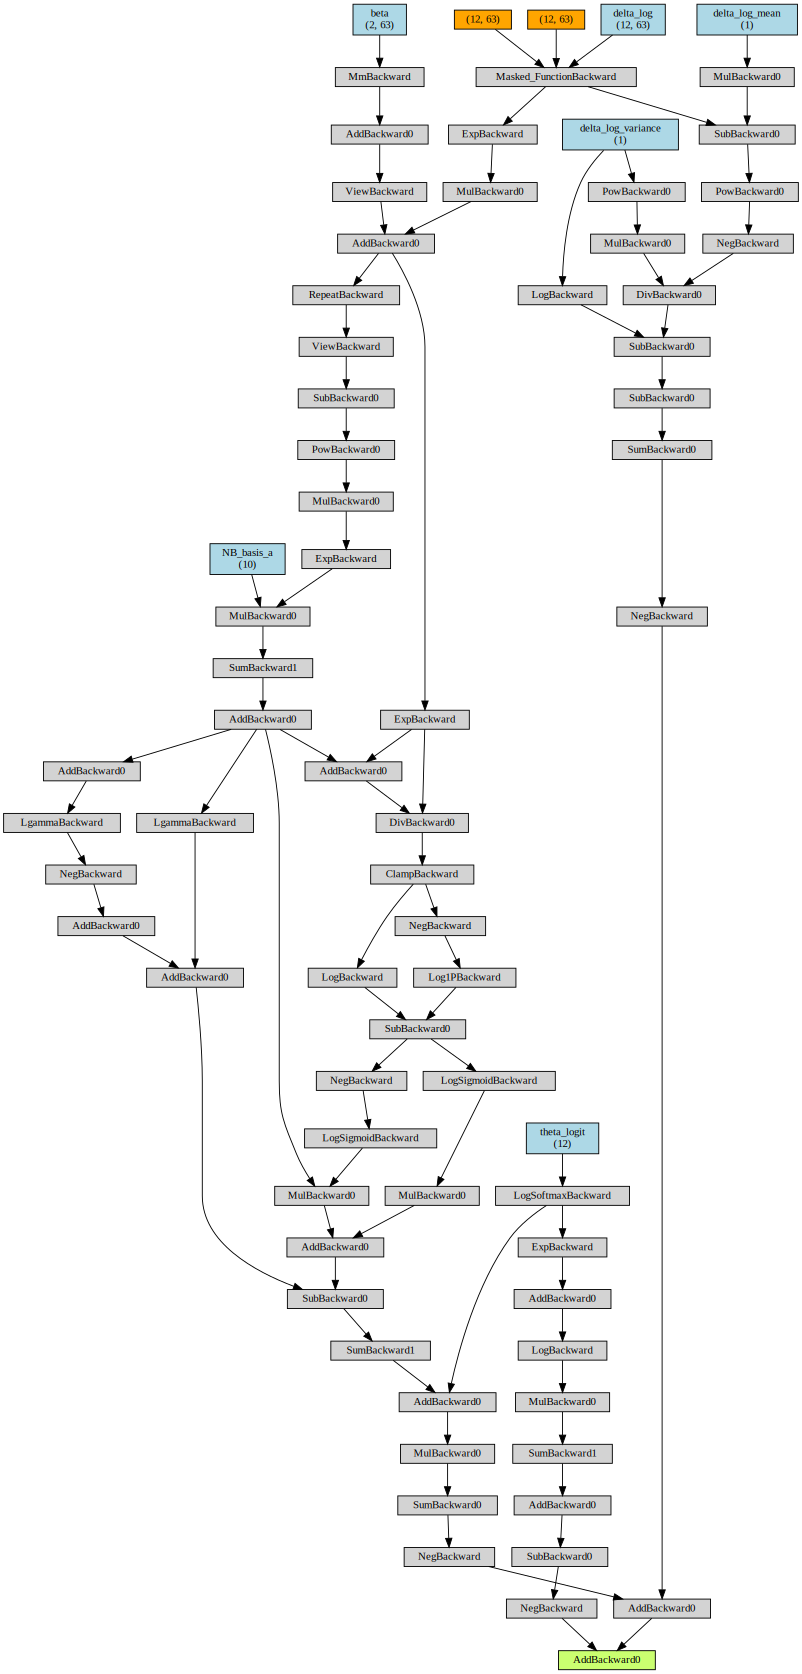

In [142]:
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
with torch.no_grad():
    for batch_idx,batch in enumerate(cell_dataloader):
        batch_Y=batch['Y'].to(device)
        batch_X=batch['X'].to(device)
        batch_s=batch['s'].to(device)    
    gamma_fixed,_,LL_old=model(batch_Y,batch_X,batch_s,gamma_fixed=None,mode='LL')
    _,Q_old,_=model(batch_Y,batch_X,batch_s,gamma_fixed=gamma_fixed,mode='M')
    
print(LL_old)
print(Q_old)


from torchviz import make_dot, make_dot_from_trace

make_dot(model(batch_Y,batch_X,batch_s,gamma_fixed=gamma_fixed,mode='M')[1],params=dict(model.named_parameters()))
#for i in model.named_parameters():
#    print(i)
    #print(i[1].grad_fn)